##### Load modules

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

##### Load data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = df_train[['text', 'target']]

##### Split train/valid/test

In [3]:
def sample_from_dataframe(df, n_sample):
    params = {'n': n_sample, 'random_state': 0}

    where = df.target == 0
    df_sample = df[where].sample(**params)

    where = df.target == 1
    df_sample = pd.concat([df_sample, df[where].sample(**params)])

    return df.drop(index=df_sample.index), df_sample

In [4]:
df_train, df_valid = sample_from_dataframe(df_train, 500)
df_train, df_test = sample_from_dataframe(df_train, 200)

In [5]:
df_train.shape, df_valid.shape, df_test.shape

((6213, 2), (1000, 2), (400, 2))

##### Tokenize text

In [6]:
def text_to_seq(tokenizer, df):
    seqs = tokenizer.texts_to_sequences(df.text)
    x = keras.preprocessing.sequence.pad_sequences(seqs)
    y = df.target.values
    return x, y

In [7]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train.text)

x_train, y_train = text_to_seq(tokenizer, df_train)
x_valid, y_valid = text_to_seq(tokenizer, df_valid)
x_test, y_test = text_to_seq(tokenizer, df_test)

In [8]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((6213, 32), (6213,), (1000, 29), (1000,), (400, 30), (400,))

##### Build and train a network

In [9]:
def build(n_words):
    params = {
        'dropout': 0.5,
        'recurrent_dropout': 0.5,
    }

    K.clear_session()

    inputs = keras.layers.Input(shape=(None, ))
    prev = keras.layers.Embedding(n_words, 64, mask_zero=True)(inputs)
    prev = keras.layers.LSTM(64, return_sequences=True, **params)(prev)
    prev = keras.layers.LSTM(64, return_sequences=True, **params)(prev)
    prev = keras.layers.LSTM(64, **params)(prev)
    outputs = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2')(prev)

    model = keras.models.Model(inputs, outputs)
    
    return model

Train on 6213 samples, validate on 1000 samples
Epoch 1/20
6213/6213 [==============================] - 10s 2ms/sample - loss: 0.6566 - accuracy: 0.6465 - val_loss: 0.5612 - val_accuracy: 0.7600
Epoch 2/20
6213/6213 [==============================] - 3s 465us/sample - loss: 0.4819 - accuracy: 0.8059 - val_loss: 0.5019 - val_accuracy: 0.7770
Epoch 3/20
6213/6213 [==============================] - 3s 467us/sample - loss: 0.3887 - accuracy: 0.8516 - val_loss: 0.4967 - val_accuracy: 0.7850
Epoch 4/20
6213/6213 [==============================] - 3s 467us/sample - loss: 0.3382 - accuracy: 0.8769 - val_loss: 0.5237 - val_accuracy: 0.7820
Epoch 5/20
6213/6213 [==============================] - 3s 464us/sample - loss: 0.2848 - accuracy: 0.9039 - val_loss: 0.5673 - val_accuracy: 0.7640
Epoch 6/20
6213/6213 [==============================] - 3s 462us/sample - loss: 0.2535 - accuracy: 0.9145 - val_loss: 0.5877 - val_accuracy: 0.7750
Epoch 7/20
6213/6213 [==============================] - 3s 464us/

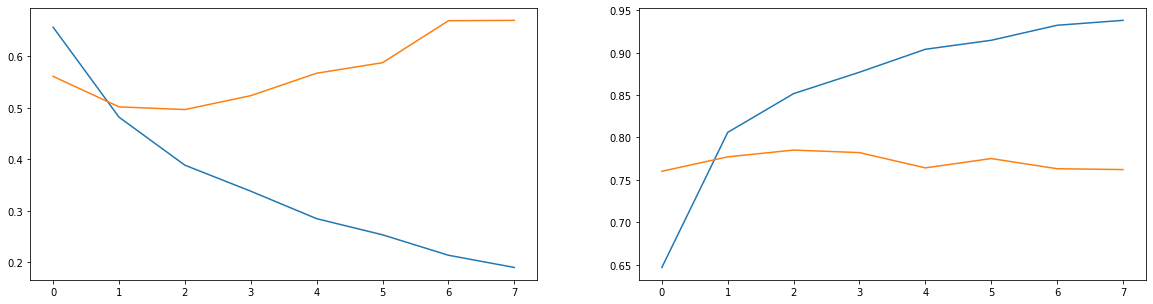

In [10]:
optimizer = keras.optimizers.RMSprop()
earlystop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = build(np.max(x_train) + 1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=256, epochs=20, callbacks=[earlystop])

plt.figure(figsize=[20, 5])

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.show()

##### Evaluate on validation / test set

In [11]:
def evaluate(y_true, y_pred):
    f1 = f1_score(y_true, y_pred) * 100
    print(f'f1_score is {f1:.2f}')
    print()
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / y_true.shape[0] * 2
    ConfusionMatrixDisplay(cm, ['0', '1']).plot()
    plt.show()

f1_score is 75.98



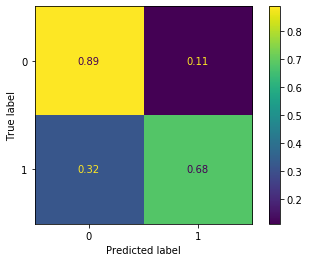

In [12]:
y_hat = model.predict(x_valid, batch_size=512)
y_pred = y_hat >= 0.5
evaluate(y_valid, y_pred)

f1_score is 77.87



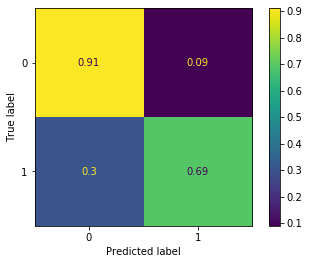

In [13]:
y_hat = model.predict(x_test, batch_size=512)
y_pred = y_hat >= 0.5
evaluate(y_test, y_pred)

##### Error diagnosis

In [14]:
pd.set_option('max_colwidth', 500)
y_hat = model.predict(x_valid, batch_size=512)
df_valid['error'] = np.abs(y_valid.reshape(-1) - y_hat.reshape(-1))
df_valid['seq'] = tokenizer.sequences_to_texts(x_valid)
df_valid.sort_values('error', ascending=False).head(30)

,text,target,error,seq
4618,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,0,0.970072,cleared incident with injury i 495 inner loop exit 31 md 97 georgia ave silver spring
1823,@johndcgow heard this few days ago while driving and near crashed the car from laughing to much,0,0.964125,heard this few days ago while driving and near crashed the car from laughing to much
167,Statistically I'm at more of risk of getting killed by a cop than I am of dying in an airplane accident.,0,0.954907,i'm at more of risk of getting killed by a cop than i am of dying in an airplane accident
3017,6 Things Getting Caught in a Dust Storm &amp; the Challenging Real Estate Market Have in Common (+ video): http://t.co/jf5Ft5cq9j,0,0.952935,6 things getting caught in a dust storm amp the real estate market have in common video http t co
974,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/iap4LwvqsW,1,0.948676,new ladies shoulder tote handbag faux leather hobo purse cross body bag womens http t co zujwuiomb3 http t co
6108,Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F,1,0.944648,do you feel like you are sinking in low self image take the quiz http t co http t co
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,0.942627,former township fire truck being used in philippines langley times http t co
4143,@leedsrouge Love what you picked! We're playing WORTH IT by FIFTH HARM/KID INK because of you! Listen &amp; Vote: http://t.co/0wrATkA2jL,1,0.940349,love what you picked we're playing worth it by fifth harm kid ink because of you listen amp vote http t co 0wratka2jl
2362,7 Christians detained in Zhejiang amid widespread anger over cross removal- over 1200 crosses removed since last yr http://t.co/8PICbkDJM0,0,0.939603,7 christians detained in amid widespread anger over cross removal over 1200 crosses removed since last yr http t co
2250,Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy,1,0.938211,why are you deluged with low self image take the quiz http t co http t co
